2018 Oct 9<br>
Since I'm getting a little short on time for DPS, I'm going to do a quick once-through of the planned full analysis using the Levenberg-Marquardt approach, with simplified error estimates. Later, I'll go back through with the MCMC analysis to clean up uncertainty estimates.

In [91]:
%matplotlib inline
#%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from statsmodels.robust.scale import mad
from scipy.optimize import curve_fit
from scipy.signal import lombscargle

from lightkurve import KeplerLightCurveFile
from PyAstronomy.modelSuite.XTran.forTrans import MandelAgolLC

from transit_utils import bindata, transit_duration, supersample_time
from variable_eclipses_utils import *

from BEER_curve import BEER_curve

import dill

K76 = Kepler76_params()

In [2]:
num_period = 2
binsize = 30./60./24.
    
# Retrieve while masking out transit
time, flux, filtered_time, filtered_flux = retreive_data(K76.saved_ep.per, num_periods=num_period, 
                                                         KIC=K76.KIC, fit_bottom=True, params=K76.saved_ep, 
                                                         drop_outliers=True)
folded_time = filtered_time % K76.saved_ep.per

# Estimate scatter
ind = ~transit_indices(folded_time, 2.*K76.dur, K76.T0)
unbinned_noise = mad(filtered_flux[ind])
print(unbinned_noise*1e6)

158.5868291130012


In [3]:
def fit_BEER_signals(cur_time, baseline, Aellip, Abeam, Aplanet, phase_shift):
    params = K76.saved_params.copy()

    params['baseline'] = baseline
    params['Aellip'] = Aellip
    params['Abeam'] = Abeam
    params['Aplanet'] = Aplanet
    params['phase_shift'] = phase_shift

    cur_BC = BEER_curve(cur_time, params,
            supersample_factor=10, exp_time=30./60./24.)
    
    return cur_BC.all_signals()

def fit_transit(time, baseline, a, T0, p, b, supersample_factor=10, exp_time=30./60./24.):
    params = K76.saved_params.copy()

    time_supersample = supersample_time(time, supersample_factor, exp_time)
    
    ma = MandelAgolLC(orbit="circular", ld="quad")
    ma['per'] = params['per']
    ma['a'] = a
    ma['T0'] = T0
    ma['p'] = p
    ma['i'] = np.arccos(b/a)*180./np.pi
    ma["linLimb"] = params["linLimb"]
    ma["quadLimb"] = params["quadLimb"]
    
    transit_supersample = ma.evaluate(time_supersample) - 1. + baseline
    return np.mean(transit_supersample.reshape(-1, supersample_factor), axis=1)

1.3415615117020556
[-4.34593427e-05  5.09154691e+00  6.84990158e-01  8.48417473e-02
  9.08334341e-01]
[4.61826133e-06 5.01485256e-02 2.39761774e-05 4.94852935e-04
 2.63570610e-03]


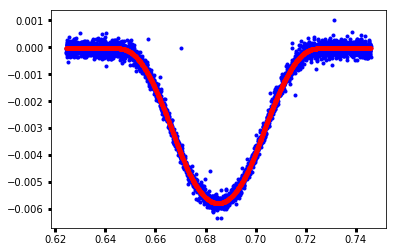

In [10]:
# Fit folded transit
bounds = ([-1000e-6, 2., K76.saved_params['T0']*0.95, 0., -1],
          [1000e-6, 10., K76.saved_params['T0']*1.05, 0.2, 1])

transit_ind = transit_indices(folded_time, 2.*K76.dur, K76.saved_params['T0'])

time = folded_time[transit_ind]
data = filtered_flux[transit_ind]
err = unbinned_noise*np.ones_like(time)

initial_guess = [0., K76.saved_params['a'], K76.saved_params['T0'], K76.saved_params['p'], K76.saved_params['b']]
transit_popt, transit_pcov = curve_fit(fit_transit, time, data, sigma=err, p0=initial_guess, bounds=bounds)

transit_uncertainties = np.sqrt(transit_pcov.diagonal())

print(transit_popt)
print(transit_uncertainties)

plt.plot(time, data, 'b.')
plt.plot(time, fit_transit(time, *transit_popt), 'r.')

In [11]:
def fit_transit_midtime(time, baseline, T0, 
                        transit_params=transit_popt, supersample_factor=10, exp_time=30./60./24.):
    time_supersample = supersample_time(time, supersample_factor, exp_time)
    
    params = K76.saved_params.copy()
    
    ma = MandelAgolLC(orbit="circular", ld="quad")
    ma['per'] = params['per']
    ma['a'] = transit_params[1]
    ma['T0'] = T0
    ma['p'] = transit_params[3]
    ma['i'] = np.arccos(transit_params[4]/transit_params[1])*180./np.pi
    ma["linLimb"] = params["linLimb"]
    ma["quadLimb"] = params["quadLimb"]
    
    transit_supersample = ma.evaluate(time_supersample) - 1. + baseline
    return np.mean(transit_supersample.reshape(-1, supersample_factor), axis=1)

<ErrorbarContainer object of 3 artists>

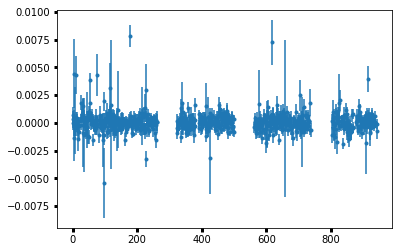

In [233]:
# Fitting transit ephemeris
mn = np.min(filtered_time)
mx = np.min(filtered_time) + K76.saved_params['per']

current_transit_num = 0
transit_nums = []
mid_transit_times = np.array([])
mid_transit_times_err = np.array([])
while(mn <= np.max(filtered_time) - K76.saved_params['per']):
#while(mn < np.min(filtered_time) + 2.*K76.saved_params['per']):
    
    ind = (filtered_time >= mn) & (filtered_time < mx)
    unfolded_time = filtered_time[ind]
    time = folded_time[ind]
    data = filtered_flux[ind]
    err = unbinned_noise*np.ones_like(time)
    
    transit_ind = transit_indices(time, 2.*K76.dur, K76.saved_params['T0'])
    # At least three points in transit
    if(time[transit_ind].size >= 3):

        bounds = ([-1000e-6, K76.saved_params['T0']*0.95],
          [1000e-6, K76.saved_params['T0']*1.05])

        initial_guess = [0., K76.saved_params['T0']]
        single_transit_popt, single_transit_pcov = curve_fit(fit_transit_midtime, time, data, sigma=err,
                                                             p0=initial_guess, bounds=bounds)
        single_transit_uncertainties = np.sqrt(single_transit_pcov.diagonal())

        if(single_transit_uncertainties[1] > 0):
            transit_nums.append(current_transit_num)
            mid_transit_times = np.append(mid_transit_times, single_transit_popt[1] +\
                                          np.floor(np.min(filtered_time[ind])/K76.saved_params['per'])*\
                                          K76.saved_params['per'])
            mid_transit_times_err = np.append(mid_transit_times_err, single_transit_uncertainties[1])
            
#             plt.plot(filtered_time[ind], data, 'b.')
#             plt.plot(filtered_time[ind], fit_transit_midtime(time, *single_transit_popt), 'r.', alpha=0.5)
#             plt.axvline(single_transit_popt[1] +\
#                         np.floor(np.min(filtered_time[ind])/K76.saved_params['per'])*K76.saved_params['per'])

    current_transit_num += 1
    mn += K76.saved_params['per']
    mx += K76.saved_params['per']
    
plt.errorbar(transit_nums, mid_transit_times - K76.saved_params['per']*np.array(transit_nums) - mid_transit_times[0], 
             mid_transit_times_err, marker='.', ls='')

1.544928932, 132.004132390
[9.07993126e-08 4.52744443e-05]
1.544928750
928.9618577761502


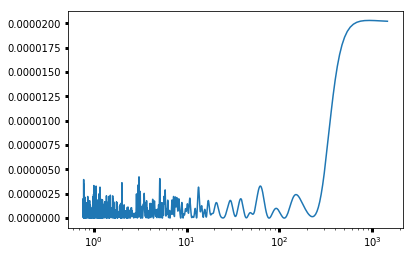

In [236]:
# Fit new period
def fit_line(x, m, b):
    return m*x + b

bounds = ([K76.saved_params['per']*0.95, np.min(filtered_time) - K76.saved_params['per']],
          [K76.saved_params['per']*1.05, np.min(filtered_time) + K76.saved_params['per']])
initial_guess = [K76.saved_params['per'], np.min(filtered_time)]
ephemeris_popt, ephemeris_pcov = curve_fit(fit_line, transit_nums, mid_transit_times, sigma=mid_transit_times_err, 
                                          p0=initial_guess, bounds=bounds)
ephemeris_uncertainties = np.sqrt(ephemeris_pcov.diagonal())

print("%11.9f, %11.9f" % (ephemeris_popt[0], ephemeris_popt[1]))
print(ephemeris_uncertainties)
print("%11.9f" % K76.saved_params['per'])

expected_mid_transit_times = np.array(transit_nums)*K76.saved_params['per']
O_minus_C = mid_transit_times - expected_mid_transit_times - np.min(filtered_time)

# plt.errorbar(transit_nums, mid_transit_times - np.polyval(ephemeris_popt, transit_nums), mid_transit_times_err, 
#              marker='.', ls='')

# And finally check for any periodic signals -
#  https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.lombscargle.html
nout = 10000
max_freq = 2./np.min(mid_transit_times[1:] - mid_transit_times[0:-1])
min_freq = 1./(np.max(mid_transit_times) - np.min(mid_transit_times[0:-1]))
f = np.linspace(min_freq, max_freq, nout)
pgram = lombscargle(mid_transit_times, mid_transit_times - np.polyval(ephemeris_popt, transit_nums), f)

# No peak (except for peak for whole time span) is more than barely above the other peaks, suggesting no periodicity
plt.semilogx(1./f, pgram)
print((1./f)[np.argmax(pgram)])

[ 2.64089317e-05  1.30011592e-05  6.49105108e-06  5.00270473e-05
 -1.44826070e-02]
[8.07606140e-07 1.24506364e-06 1.01639774e-06 1.21738473e-06
 3.26418850e-10]
(-1.654680999957358e-06, 0.0001537816630887722)


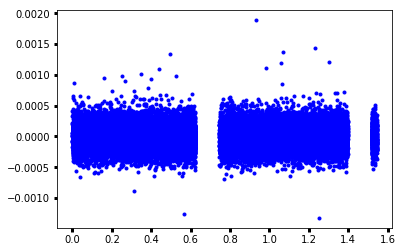

In [47]:
bounds = ([-500e-6, -500e-6, -500e-6, 0., -1],
          [500e-6, 500e-6, 500e-6, 500e-6, 1])

out_of_transit_ind = ~(transit_indices(folded_time, 2.*K76.dur, K76.saved_params['T0']) | 
                       transit_indices(folded_time, 2.*K76.dur, K76.saved_params['T0'] + 0.5*K76.saved_params['per']))
unbinned_noise = mad(filtered_flux[out_of_transit_ind])

time = folded_time[out_of_transit_ind]
data = filtered_flux[out_of_transit_ind]
err = unbinned_noise*np.ones_like(time)

initial_guess = [0., K76.saved_params['Aellip'], K76.saved_params['Abeam'], K76.saved_params['Aplanet'], 
                 K76.saved_params['phase_shift']]
BEER_popt, BEER_pcov = curve_fit(fit_BEER_signals, time, data, p0=initial_guess, bounds=bounds)
BEER_uncertainties = np.sqrt(BEER_pcov.diagonal())

print(BEER_popt)
print(BEER_uncertainties)

resid = data - fit_BEER_signals(time, *BEER_popt)
print(np.median(resid), mad(resid))

plt.plot(time, resid, 'b.')
# plt.plot(binned_time, binned_data, 'b.')
# plt.plot(time, fit_all_signals(time, *popt), 'r.')
#plt.ylim([-100e-6, 100e-6])

flux_no_BEER = filtered_flux - fit_BEER_signals(folded_time, *BEER_popt)

# Filtering with num_periods = 1
# [ 2.81406696e-05  1.30099611e-05  5.48450688e-06  4.73176998e-05
#  -1.52278158e-02]
# [7.29596464e-07 1.12511986e-06 9.18915799e-07 1.10022355e-06
#  2.79756907e-10]
# (-1.9315925643068677e-06, 0.00013777918955235323)
#
# Filtering using num_periods = ** 2 **
# [ 2.64089317e-05  1.30011592e-05  6.49105108e-06  5.00270473e-05
#  -1.44826070e-02]
# [8.07606140e-07 1.24506364e-06 1.01639774e-06 1.21738473e-06
#  3.26418850e-10]
# (-1.654680999957358e-06, 0.0001537816630887722)
#
# Filtering using num_periods = 3
# [ 2.68510817e-05  1.29427031e-05  6.42103847e-06  5.03077454e-05
#  -1.42409198e-02]
# [8.46753952e-07 1.30549361e-06 1.06503443e-06 1.27629982e-06
#  3.43724280e-10]
# (-9.088163305233599e-07, 0.00016243630887631966)
#
# Filtering using num_periods = 4
# [ 2.63036465e-05  1.27559563e-05  6.67388257e-06  5.01237078e-05
#  -1.47716115e-02]
# [8.96972640e-07 1.38304569e-06 1.12893102e-06 1.35234703e-06
#  3.63578233e-10]
# (-5.156132152746817e-07, 0.0001730449194908712)
#
# Filtering using num_periods = 5
# [ 2.53902537e-05  1.27039443e-05  6.63722062e-06  5.06214011e-05
#  -1.45652398e-02]
# [9.47968062e-07 1.46177792e-06 1.19295412e-06 1.42904140e-06
#  3.87772879e-10]
# (-5.039941071848612e-07, 0.00018254965794037224)
#
# Filtering using num_periods = 6
# [ 2.57010171e-05  1.26924239e-05  6.99643578e-06  5.03132150e-05
#  -1.53618335e-02]
# [9.77220256e-07 1.50668920e-06 1.23060995e-06 1.47384628e-06
#  3.98529076e-10]
# (-7.32561660051048e-07, 0.0001864452806670191)
#
# Filtering using num_periods = 7
# [ 2.44068854e-05  1.25367324e-05  6.85848070e-06  5.08177319e-05
#  -1.49392240e-02]
# [9.87584791e-07 1.52269606e-06 1.24303155e-06 1.48913388e-06
#  4.06066484e-10]
# (-6.079805391979691e-07, 0.00018680093797449786)

In [60]:
def fit_eclipse(time, baseline, eclipse_depth, 
                        transit_params=transit_popt, supersample_factor=10, exp_time=30./60./24.):
    time_supersample = supersample_time(time, supersample_factor, exp_time)
    
    params = K76.saved_params.copy()
    
    ma = MandelAgolLC(orbit="circular", ld="quad")
    ma['per'] = ephemeris_popt[0]
    ma['a'] = transit_params[1]
    ma['T0'] = (ephemeris_popt[1] % ephemeris_popt[0]) + 0.5*params['per']
    ma['p'] = np.sqrt(np.abs(eclipse_depth))*np.sign(eclipse_depth)
    ma['i'] = np.arccos(transit_params[4]/transit_params[1])*180./np.pi
    ma["linLimb"] = 0.
    ma["quadLimb"] = 0.
    
    transit_supersample = ma.evaluate(time_supersample) - 1. + baseline
    return np.mean(transit_supersample.reshape(-1, supersample_factor), axis=1)

12


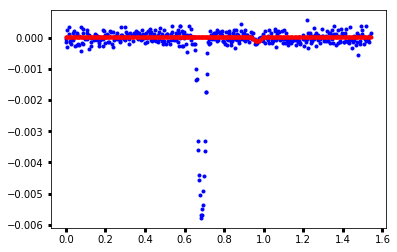

In [94]:
# Fitting eclipses
bounds = ([-1000e-6, -1000e-6],
          [1000e-6, 1000e-6])

num_periods_to_fold = 8.

mn = np.min(filtered_time)
mx = np.min(filtered_time) + num_periods_to_fold*K76.saved_params['per']

# eclipse_times = {}
# eclipse_depths = {}
# eclipse_depths_uncertainties = {}

# eclipse_times[num_periods_to_fold] = [np.array([])]
# eclipse_depths[num_periods_to_fold] = [np.array([])]
# eclipse_depths_uncertainties[num_periods_to_fold] = [np.array([])]
while(mx <= np.max(filtered_time) - num_periods_to_fold*ephemeris_popt[0]):
    
    ind = (filtered_time >= mn) & (filtered_time < mx)
    time = folded_time[ind]
    data = flux_no_BEER[ind]
    err = unbinned_noise*np.ones_like(time)
    
    eclipse_ind = transit_indices(time, 2.*K76.dur, (ephemeris_popt[1] % ephemeris_popt[0]) + 0.5*ephemeris_popt[0])
    # At least three points in transit
    if(time[eclipse_ind].size >= 6):

        try:        
            # Only look at eclipse!
            time = time[eclipse_ind]
            data = data[eclipse_ind]
            err = unbinned_noise*np.ones_like(time)

            initial_guess = [0., 0.]
            eclipse_popt, eclipse_pcov = curve_fit(fit_eclipse, time, data, sigma=err, p0=initial_guess, bounds=bounds)
            eclipse_uncertainties = np.sqrt(eclipse_pcov.diagonal())

            # Rescale uncertainties
            redchisq = redchisqg(data, fit_eclipse(time, *eclipse_popt), 2, err)
            
            eclipse_times[num_periods_to_fold] =\
                np.append(eclipse_times[num_periods_to_fold], np.mean(filtered_time[ind]))
            eclipse_depths[num_periods_to_fold] = np.append(eclipse_depths[num_periods_to_fold], eclipse_popt[1])
            eclipse_depths_uncertainties[num_periods_to_fold] =\
                np.append(eclipse_depths_uncertainties[num_periods_to_fold], 
                          eclipse_uncertainties[1]*np.sqrt(redchisq))
            
            if(eclipse_popt[1]/(eclipse_uncertainties[1]*np.sqrt(redchisq)) > 3):
                # Convince me that you are actually detecting the eclipse!
                plt.plot(folded_time[ind], flux_no_BEER[ind], 'b.')
                plt.plot(folded_time[ind], fit_eclipse(folded_time[ind], *eclipse_popt), 'r.')
                break
            
        except:
            pass

    mn += K76.saved_params['per']
    mx += K76.saved_params['per']
    
# print(eclipse_depths)
# print(eclipse_depths_uncertainties)

ind = eclipse_depths[num_periods_to_fold]/eclipse_depths_uncertainties[num_periods_to_fold] > 3.
print(eclipse_depths[num_periods_to_fold][ind].size)

#plt.errorbar(eclipse_times[ind], eclipse_depths[ind], eclipse_depths_uncertainties[ind], marker='.', ls='')

# When num_periods_to_fold = 1
# ind = eclipse_depths/eclipse_depths_uncertainties > 3.
# print(eclipse_depths[ind].size)
# 0
#
# When num_periods_to_fold = 2
# ind = eclipse_depths/eclipse_depths_uncertainties > 3.
# print(eclipse_depths[ind].size)
# 17
#
# When num_periods_to_fold = 3
# ind = eclipse_depths/eclipse_depths_uncertainties > 3.
# print(eclipse_depths[ind].size)
# 12
#
# When num_periods_to_fold = 4
# ind = eclipse_depths/eclipse_depths_uncertainties > 3.
# print(eclipse_depths[ind].size)
# 14
#
# When num_periods_to_fold = 5
# ind = eclipse_depths/eclipse_depths_uncertainties > 3.
# print(eclipse_depths[ind].size)
# 15
#
# When num_periods_to_fold = 6
# ind = eclipse_depths/eclipse_depths_uncertainties > 3.
# print(eclipse_depths[ind].size)
# 14
#
# When num_periods_to_fold = 7
# ind = eclipse_depths/eclipse_depths_uncertainties > 3.
# print(eclipse_depths[ind].size)
# 14
#
# When num_periods_to_fold = 8
# ind = eclipse_depths/eclipse_depths_uncertainties > 3.
# print(eclipse_depths[ind].size)
# 10

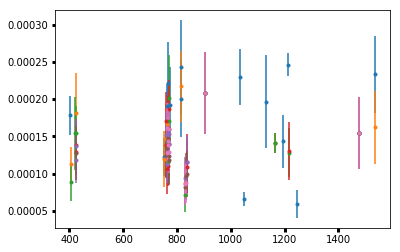

In [92]:
for cur_key in eclipse_depths.keys():
    ind = eclipse_depths[cur_key]/eclipse_depths_uncertainties[cur_key] > 3.
    plt.errorbar(eclipse_times[cur_key][ind], eclipse_depths[cur_key][ind], 
                 eclipse_depths_uncertainties[cur_key][ind], marker='.', ls='')
    
dill.dump_session("Analyzing_Kepler76b_with_LM_2018Oct11_1-08p.pkl")